In [4]:
pip install numpy h5py tensorflow

In [5]:
import numpy as np
import h5py
from tensorflow.keras.datasets import mnist

# Step 1: Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Step 2: Normalize the pixel values (scale to [0, 1])
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Step 3: Reshape data to add a channel dimension (optional, for CNNs)
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape: (10000, 28, 28, 1)

# Step 4: Save data to an HDF5 file
with h5py.File('mnist_sign_digits.h5', 'w') as h5f:
    h5f.create_dataset('x_train', data=x_train)
    h5f.create_dataset('y_train', data=y_train)
    h5f.create_dataset('x_test', data=x_test)
    h5f.create_dataset('y_test', data=y_test)

print("MNIST dataset has been saved as mnist_sign_digits.h5")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MNIST dataset has been saved as mnist_sign_digits.h5


In [8]:
import math
import scipy
import h5py
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops

In [13]:
def load_dataset():
    with h5py.File('mnist_sign_digits.h5', 'r') as h5f:
        # Access datasets
        train_images = h5f['x_train'][:]
        train_labels = h5f['y_train'][:]
        test_images = h5f['x_test'][:]
        test_labels = h5f['y_test'][:]
    # Print shapes to verify the data
    print("Train Images shape:", train_images.shape)
    print("Train Labels shape:", train_labels.shape)
    print("Test Images shape:", test_images.shape)
    print("Test Labels shape:", test_labels.shape)
    return train_images, train_labels, test_images, test_labels

In [14]:
train_images, train_labels, test_images, test_labels = load_dataset()

Train Images shape: (60000, 28, 28, 1)
Train Labels shape: (60000,)
Test Images shape: (10000, 28, 28, 1)
Test Labels shape: (10000,)


In [15]:
def zero_padding(X, pad_values):
    return np.pad(X, ((0,0), (pad_values,pad_values), (pad_values,pad_values), (0,0)), mode='constant', constant_values = (0,0))

In [16]:
def conv_1_layer (A_prev, W_filter, b):
    a = np.multiply(A_prev, W_filter)
    return np.sum(a) + float(b)

In [17]:
def fwd_conv (A_prev, W, b, hparameters):
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    f, f, n_C_prev, n_C = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    n_H = (int)((n_H_prev + (2 * pad) - f) / stride) + 1
    n_W = (int)((n_W_prev + (2 * pad) - f) / stride) + 1
    Z = np.zeros((m,n_H, n_W,n_C))
    A_prev_pad = zero_padding(A_prev,pad)

    for i in range(0,m):
        a_prev_pad = A_prev_pad[i]
        print(a_prev_pad.shape)
        for h in range(0,a_prev_pad.shape[0],stride):
            vert_start = h
            vert_end = h + f

            if (vert_end > a_prev_pad.shape[0]):
                    break
            for w in range(0,a_prev_pad.shape[1],stride):
                horiz_start = w
                horiz_end = w + f

                if (horiz_end > a_prev_pad.shape[1]):
                    break

                for c in range(0,W.shape[3]):
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    weights = np.sum(a_slice_prev * W[:,:,:,c])
                    biases = b[0][0][0][c]
                    Z[i, (int)(h/stride), (int)(w/stride), c] = weights + biases
    cache = (A_prev, W, b, hparameters)

  return Z, cache

In [19]:
def fwd_pool1(A_prev, hparameters, mode = "max"):
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    A = np.zeros((m, n_H, n_W, n_C))
    for i in range(0,m):
        for h in range(0,A_prev.shape[1],stride):
            vert_start = h
            vert_end = h + f
            if (vert_end > A_prev.shape[1]):
                break

            for w in range(0,A_prev.shape[2],stride):
                horiz_start = w
                horiz_end = w + f

                if (horiz_end > A_prev.shape[2]):
                    break

                for c in range (0,A.shape[3]):


                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]

                    if mode == "max":
                        A[i, (int)(h/stride), (int)(w/stride), c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, (int)(h/stride), (int)(w/stride), c] = np.mean(a_prev_slice)
    cache = (A_prev, hparameters)
    return A, cache

In [22]:
X_train = train_images/255.
X_test = test_images/255.

# Reshape
Y_train = train_labels.T
Y_test = test_labels.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000,)


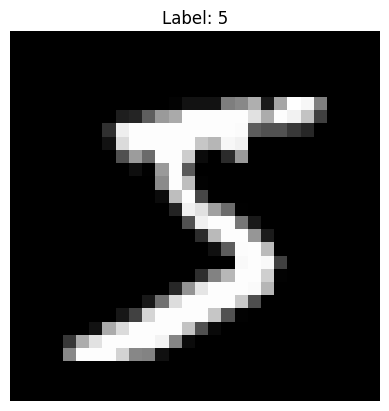

In [25]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap='gray')  # Use 'gray' colormap since MNIST is grayscale
plt.title(f"Label: {Y_train[0]}")
plt.axis('off')  # Hide axes for better visualization
plt.show()